# 🔮 Прогнозы и предсказания поведения клиентов в фитнес-клубе "Культурист-датасейнтист"

## 📜 Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. 

В этом проекте:

1. Срогнозируем вероятность оттока (на уровне следующего месяца) для каждого клиента;
2. Сформируем типичные портреты пользователей: выделим несколько наиболее ярких групп и охарактеризуем их основные свойства.
3. Проанализируем основные признаки, наиболее сильно влияющие на отток.
4. В конце исследования, сформулируем рекомендации по повышению качества работы с клиентами:
        – выделим целевые группы клиентов;
        – предложим меры по снижению оттока;
        – определим другие особенности взаимодействия с клиентами.

## Содержание
<a id='return_to_top'>

1. [🧰 Импортируем библиотеки](#import_lib)
2. [🛒 Загружаем данные](#upload)
3. [🧹 Предобработка данных](#preprocessing)
4. [🔦 Исследовательский анализ данных (EDA)](#EDA)
5. [🧪Модель прогнозирования оттока пользователей](#churn_model)
6. [🧠Общий вывод](#total)

## 🧰 Импортируем библиотеки <a id="import_lib"></a>

In [24]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


#Визуал
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels

#Препроцесcинг ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Классификаторы
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Кластеризаторы
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

#Метрики качества классификаторов
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, f1_score

## 🛒 Загружаем данные <a id="upload"></a>

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


**Описание столбцов**

    'Churn' — факт оттока в текущем месяце;
    'gender' — пол
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр
    'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
    'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
    'Phone' — наличие контактного телефона
    'Age' — возраст
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
    'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
    'Group_visits' — факт посещения групповых занятий
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### 🧠Вывод

С данными все в порядке: дубликатов и пропусков нет, типы данных правильные. Приведём все названия столбцов к нижнему регистру.

## 🧹 Предобработка данных <a id="preprocessing"></a>

In [6]:
#Приведём названия столбцов в нижний регистр 
df.columns = df.columns.str.lower()

### 🔦 Исследовательский анализ данных (EDA) <a id="EDA"></a>

In [7]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [8]:
#Посмотрим на распределение данных по нашей целевой переменной — Churn
print(df['churn'].value_counts())

0    2939
1    1061
Name: churn, dtype: int64


In [9]:
print("Доля людей нелояльных клиентов в нашем датафрейме", df['churn'].mean())

Доля людей нелояльных клиентов в нашем датафрейме 0.26525


<a id="churn_group"></a>

### 🧠Вывод

    📌 Мужчин и женщин в фитнес-клубе одинаковое количество
    📌 84% клиентов живёт в районе, где находится фитнес-центр.
    📌 48% клиентов сотрудники компаний-партнёров клуба.
    📌 30% клиентов при покупке абонемента использовали промокод от знакомого.
    📌 41% клиентов посещают групповые занятия.
    📌 Средний возраст посетителей клуба 29 лет, самому младшему клиенту 18, самому старшему 41.
    📌 75% клиентов в возрасте до 31 года. 25% клиентов в возрасте от 31 до 41 года.
    📌 Средняя выручка с доп.услуг 147. 
    📌 75% клиентов в среднем тратят на доп.услуги до 211. 25% клиентов от 211 до 552.
    📌 среднее количество месяцев посещения 3,7
    📌 среднее количество посещений в неделю за все время практически совпадает с количеством за текущий месяц и составляет ~2 посещения в неделю
    📌 2939 пользователей из 4000 — лояльные, значение переменной Churn у них — 0.
    📌 26,5% — довольно плохой показатель для компании, с таким процентом оттока можно и разориться.


In [10]:
#Посмотрим каковы средние значения числовых признаков среди лояльных(0)/нелояльных(1) пользователей?
churn_group = df.groupby('churn').mean()
churn_group.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


#### 📊 Столбчатые гистограммы для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

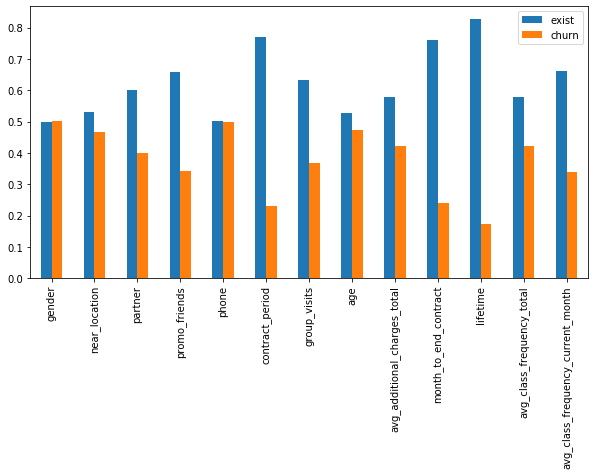

In [11]:
# сначала найдём долю каждого признака
for column in df.columns[:-1]:
    churn_group[column] = (churn_group[column] / (churn_group[column].max()+churn_group[column].min()))

churn_group_mean = churn_group.transpose()
churn_group_mean.columns = ['exist', 'churn']

# строим bar-plot
churn_group_mean.plot(kind='bar',figsize=(10, 5))

#### 📊 Распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [12]:
# создаем копию датафрейма и переименовываем значения столбца churn
df_temp = df.copy()

In [25]:
def replacer (df, col, old_value, new_value):
    """
    Производит замену значений в столбцах
    переменные: df, col, old_value, new_value
    """
    for i in col:
        df[col] = df[col].replace(old_value, new_value)

In [26]:
replacer(df_temp, 'churn', [0, 1], ['exist', 'churn'])
df_temp.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,exist
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,exist
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,exist
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,exist
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,exist


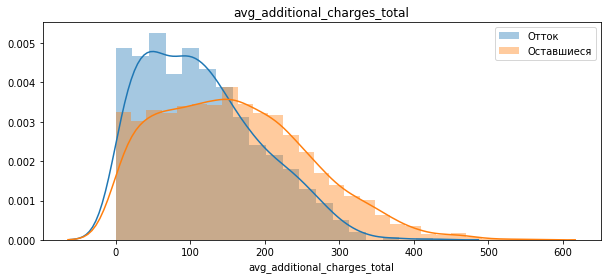

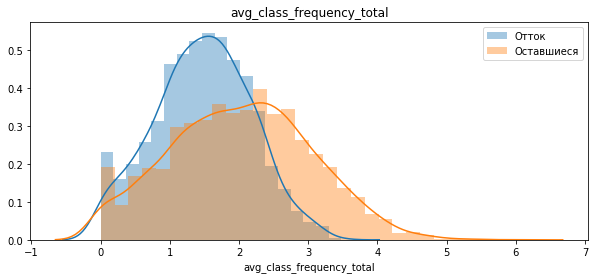

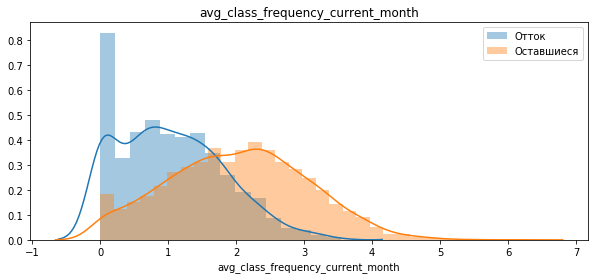

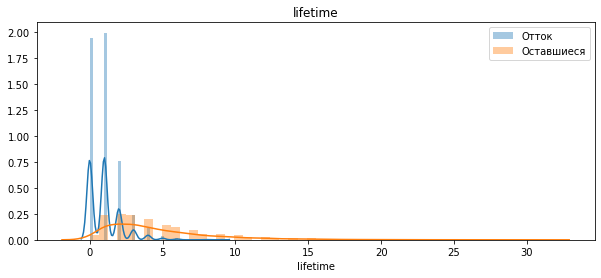

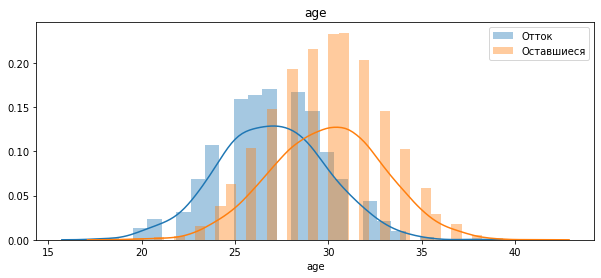

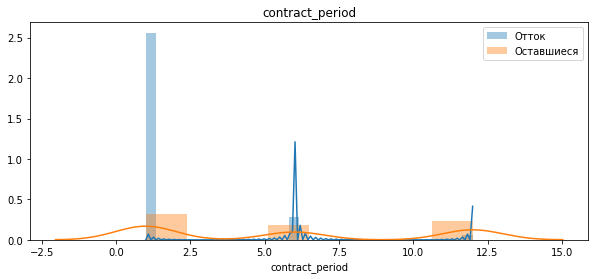

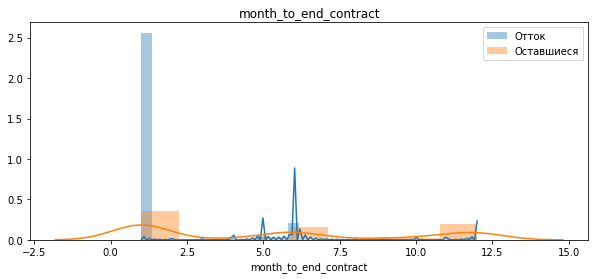

In [27]:
# Выделим в отдельный словарь количественные переменные
distplot_columns = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                    'avg_class_frequency_current_month', 'lifetime', 'age', 
                    'contract_period', 'month_to_end_contract']
# Построим гистограммы 
left = df[df['churn']==1]
stayed = df[df['churn']==0]
for column in distplot_columns: 
  plt.figure(figsize=(10,4)) 
  plt.title(column)
  sns.distplot(left[column])
  sns.distplot(stayed[column])
  plt.legend(['Отток', 'Оставшиеся'])
  plt.show()

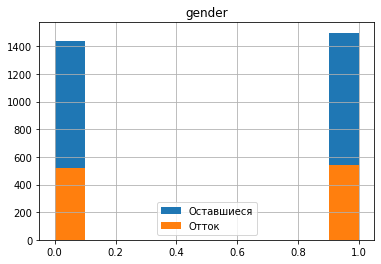

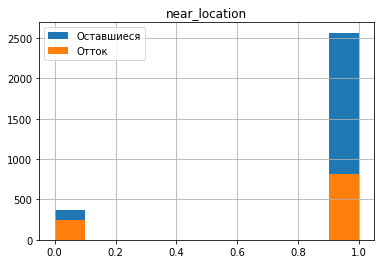

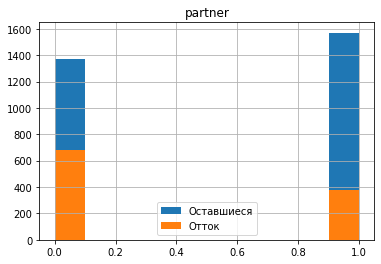

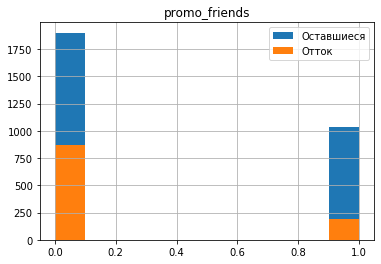

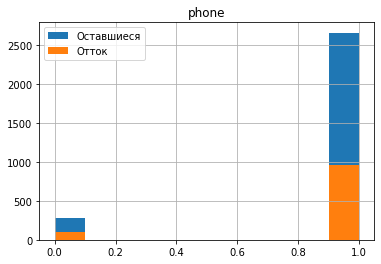

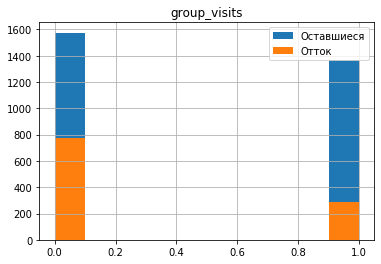

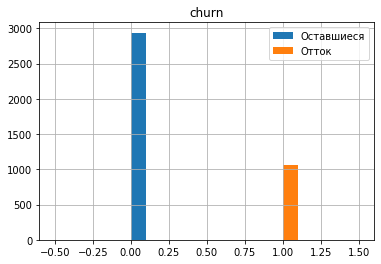

In [28]:
# Посмотрим на распеределения категориальных переменных
for column in df.columns:
  if column not in distplot_columns:
    df.groupby('churn')[column].hist()
    plt.title(column)
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show()

### 🧠 Выводы по графикам 
Распределения признаков подтверждают выводы полученные при анализе признаков сгруппированных по <code>churn</code>  
[Выводы по churn_group](#churn_group)

#### 📊 Матрица коореляций

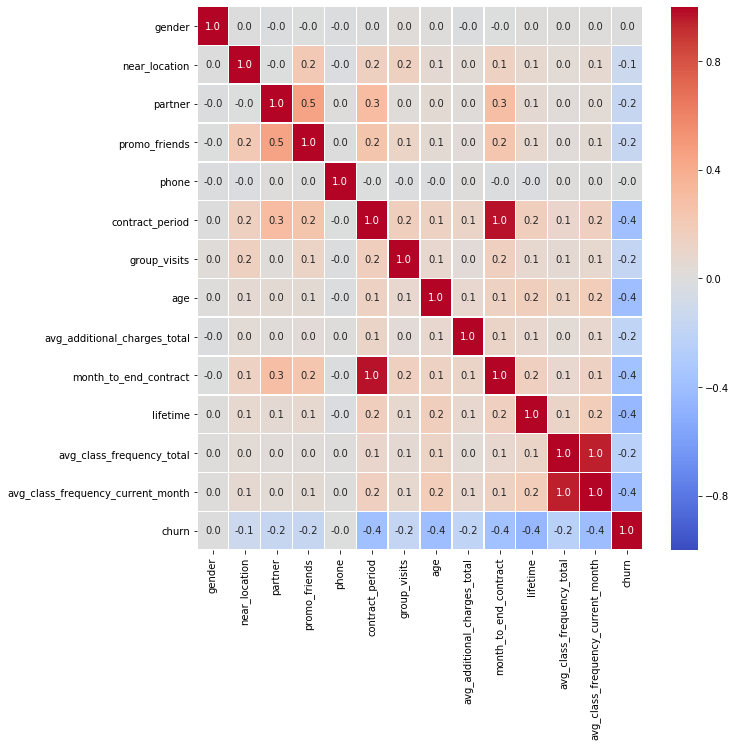

In [29]:
plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, center=0, annot=True, linewidths=.5, fmt=".1f")

### 🧠 Выводы по матрицы коореляции
* чем больше партнеров и ближе к дому клуб тем выше показатель "приведи друга"
* количество партнеров, близость к дому и наличие друзей также положительно влияют на длительность действующего абонемента

* уровень оттока снижается если:
  * больше друзей
  * ближе к дому
  * больше партнеров
  * клиент постоянный (высокий лайфтайм)
  * человек старше
  * ходит часто и много тратит на доп.услуги
  * посещает групповые занятия
  
признаки: <code>month_to_end_contract</code> и <code>contract_period</code>, а также <code>avg_class_frequency_total</code> и <code>avg_class_frequency_current_month</code> очень сильно коррелируют, так как являются очень близкими показателями, возможно по одному признаку из пары стоит удалить перед обучением.

## 🧪 Модель прогнозирования оттока пользователей <a id="churn_model"></a>

In [30]:
# Разделим датасет на 2 части: признаки X и целевую переменную y
X = df.drop(['churn'], axis=1)
y = df.churn

### Логистическая регрессия

In [31]:
#Разбиваем данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [34]:
#Создаём модель, записываем в неё экземпляр LogisticRegression()
lr_model = LogisticRegression(random_state=42, solver='liblinear')

In [35]:
#Обучаем модель методом Ridge() с ограниченим на сумму квадратов весов т.к. у нас есть мультиколлинеарные признаки
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
lr_y_pred = lr_model.predict(X_test)

In [37]:
lr_y_probas = lr_model.predict_proba(X_test)

In [38]:
cm = confusion_matrix(y_test,lr_y_pred)
tn, fp, fn, tp = cm.ravel() # "выпрямляем" матрицу, чтобы вытащить нужные значения 

In [39]:
tn, fp, fn, tp

(567, 21, 38, 174)

In [40]:
# выведите все изученные метрики для полученного прогноза
print('Метрики для модели с линейной регрессией')
print()
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, lr_y_pred)))
print('AUC-ROC: {:.2f}'.format(roc_auc_score(y_test, lr_y_probas[:,1])))

Метрики для модели с линейной регрессией

Accuracy: 0.93
Precision: 0.89
Recall: 0.82
F1: 0.86
AUC-ROC: 0.98


Метрики достойные! Кажется, линейная регрессия неплохо умеет прогнозировать отток.

###  Случайный лес

In [41]:
#Создаём модель, записываем в неё лес
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

In [42]:
# обучаем модель "случайный лес"
header_len = '||Estimators| RMSE |Accuracy| Precision|  Recall ||'
print(header_len)
print("="*len(header_len))
print()
print('Случайный лес')
print("="*len(header_len))
for estimator in range(5, 60, 5):
    for i in range(1,5,1):
        rf_model = RandomForestClassifier(n_estimators=estimator, max_depth=i, random_state=42)
        rf_model.fit(X_train, y_train)
        pred_valid = rf_model.predict(X_test)
        rf_mse = mean_squared_error(y_test, pred_valid)
        rf_rmse = math.sqrt(rf_mse)
        print()
        print('max_depth',i)
        print('||{: ^10.1f}|{: <6.4f}|{: ^8.4f}|{: ^10.4f}|{: ^9.4f}||'\
              .format(estimator,
                      rf_rmse,
                      accuracy_score(pred_valid, y_test),
                      precision_score(pred_valid, y_test),
                      recall_score(pred_valid, y_test))
                 ) 

||Estimators| RMSE |Accuracy| Precision|  Recall ||

Случайный лес

max_depth 1
||   5.0    |0.5148| 0.7350 |  0.0000  | 0.0000  ||

max_depth 2
||   5.0    |0.4330| 0.8125 |  0.3160  | 0.9306  ||

max_depth 3
||   5.0    |0.3691| 0.8638 |  0.5425  | 0.9055  ||

max_depth 4
||   5.0    |0.3240| 0.8950 |  0.6745  | 0.9051  ||

max_depth 1
||   10.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||

max_depth 2
||   10.0   |0.4183| 0.8250 |  0.3585  | 0.9500  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 3
||   10.0   |0.3758| 0.8588 |  0.5047  | 0.9304  ||

max_depth 4
||   10.0   |0.3202| 0.8975 |  0.6840  | 0.9062  ||

max_depth 1
||   15.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||

max_depth 2
||   15.0   |0.4228| 0.8213 |  0.3396  | 0.9600  ||

max_depth 3


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


||   15.0   |0.3536| 0.8750 |  0.5755  | 0.9242  ||

max_depth 4
||   15.0   |0.3182| 0.8988 |  0.6934  | 0.9018  ||

max_depth 1
||   20.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||

max_depth 2
||   20.0   |0.4243| 0.8200 |  0.3396  | 0.9474  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 3
||   20.0   |0.3446| 0.8812 |  0.5991  | 0.9270  ||

max_depth 4
||   20.0   |0.3122| 0.9025 |  0.7123  | 0.8988  ||

max_depth 1
||   25.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 2
||   25.0   |0.4138| 0.8287 |  0.3726  | 0.9518  ||

max_depth 3
||   25.0   |0.3142| 0.9012 |  0.6840  | 0.9236  ||

max_depth 4
||   25.0   |0.3082| 0.9050 |  0.7406  | 0.8820  ||

max_depth 1
||   30.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||

max_depth 2
||   30.0   |0.4108| 0.8313 |  0.3821  | 0.9529  ||

max_depth 3
||   30.0   |0.3202| 0.8975 |  0.6698  | 0.9221  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 4
||   30.0   |0.3102| 0.9038 |  0.7311  | 0.8857  ||

max_depth 1
||   35.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||

max_depth 2


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


||   35.0   |0.4016| 0.8387 |  0.4104  | 0.9560  ||

max_depth 3
||   35.0   |0.3102| 0.9038 |  0.6981  | 0.9193  ||

max_depth 4
||   35.0   |0.3102| 0.9038 |  0.7264  | 0.8902  ||

max_depth 1
||   40.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 2
||   40.0   |0.3921| 0.8462 |  0.4434  | 0.9495  ||

max_depth 3
||   40.0   |0.3062| 0.9062 |  0.7075  | 0.9202  ||

max_depth 4
||   40.0   |0.3041| 0.9075 |  0.7406  | 0.8920  ||

max_depth 1
||   45.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 2
||   45.0   |0.4016| 0.8387 |  0.4151  | 0.9462  ||

max_depth 3
||   45.0   |0.3062| 0.9062 |  0.6981  | 0.9308  ||

max_depth 4
||   45.0   |0.3062| 0.9062 |  0.7358  | 0.8914  ||

max_depth 1
||   50.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 2
||   50.0   |0.3889| 0.8488 |  0.4528  | 0.9505  ||

max_depth 3
||   50.0   |0.3122| 0.9025 |  0.6840  | 0.9295  ||

max_depth 4
||   50.0   |0.3021| 0.9087 |  0.7453  | 0.8927  ||

max_depth 1
||   55.0   |0.5148| 0.7350 |  0.0000  | 0.0000  ||


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



max_depth 2
||   55.0   |0.3824| 0.8538 |  0.4717  | 0.9524  ||

max_depth 3
||   55.0   |0.3062| 0.9062 |  0.6934  | 0.9363  ||

max_depth 4
||   55.0   |0.2958| 0.9125 |  0.7594  | 0.8944  ||


### 🧠 Выводы 
Линейная регрессия даёт лучший результат, чем случайный лес. 

## 🗂Кластеризация пользователей

In [43]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)

In [44]:
X_sc = scaler.fit_transform(X) # обучаем нормализатор и преобразуем набор данных 

In [45]:
linked = linkage(X_sc, method = 'ward') 

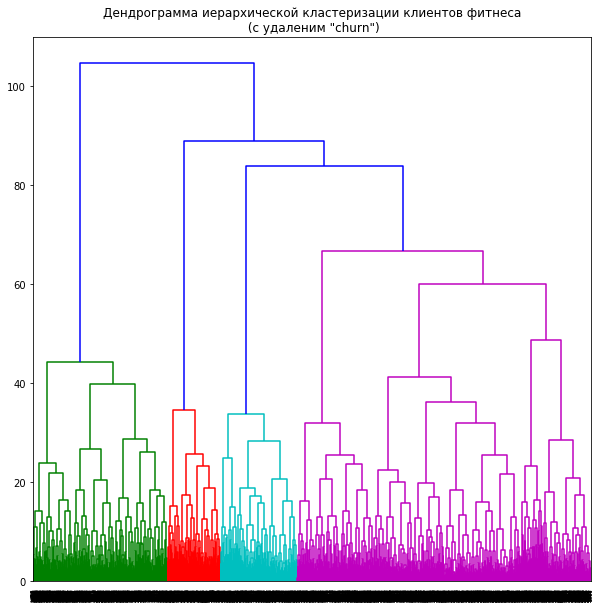

In [46]:
plt.figure(figsize=(10, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнеса\n (с удаленим "churn")')
plt.show()

In [47]:
full_sc = scaler.fit_transform(df)
linked = linkage(full_sc, method = 'ward') 

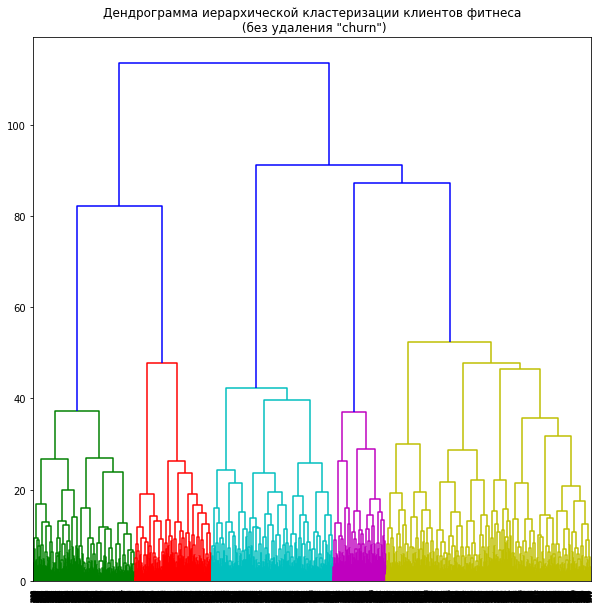

In [48]:
plt.figure(figsize=(10, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархической кластеризации клиентов фитнеса\n (без удаления "churn")')
plt.show()

### 🧠 Выводы 
Если при обучении алгоритма не показывать целевую переменную, то алгоритм видит 4 кластера, если показать то находится 5 кластеров. Ну мы то по заданию знаем, что даолжно быть 5 кластеров 🤓

### Кластеризация K-Means

In [34]:
# стандартизируем данные, обучаем модель
sc_km = StandardScaler()
x_sc_km = sc_km.fit_transform(X)
# строим прогноз
km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(x_sc_km)
# добавляем столбец с кластерами и группируем по кластерам, находим среднее
df['cluster_km'] = labels
clusters_grouped = df.groupby('cluster_km').mean().T
clusters_grouped

cluster_km,0,1,2,3,4
gender,0.502370,0.554556,0.499422,0.485738,0.523316
near_location,0.949447,0.849269,0.937572,0.718011,0.862694
partner,0.829384,0.263217,0.737572,0.299919,0.471503
promo_friends,0.998420,0.052868,0.478613,0.018745,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.097946,2.606299,11.854335,1.914425,4.777202
group_visits,0.448657,0.436445,0.546821,0.276284,0.427461
age,29.104265,30.008999,29.905202,28.083945,29.297927
avg_additional_charges_total,141.774331,159.774265,163.509804,129.496414,144.208179
month_to_end_contract,2.887836,2.419573,10.812717,1.821516,4.466321


In [35]:
cluster_df = df.copy()

In [36]:
def amount(df, cluster):
    print(f'Доля кластера {cluster}:', (df.query('cluster_km==@cluster').shape[0]/df.shape[0])*100, '%')
 
clusters = range(0,5)

for i in clusters:
    amount(cluster_df, i)

Доля кластера 0: 15.825 %
Доля кластера 1: 22.225 %
Доля кластера 2: 21.625 %
Доля кластера 3: 30.675 %
Доля кластера 4: 9.65 %


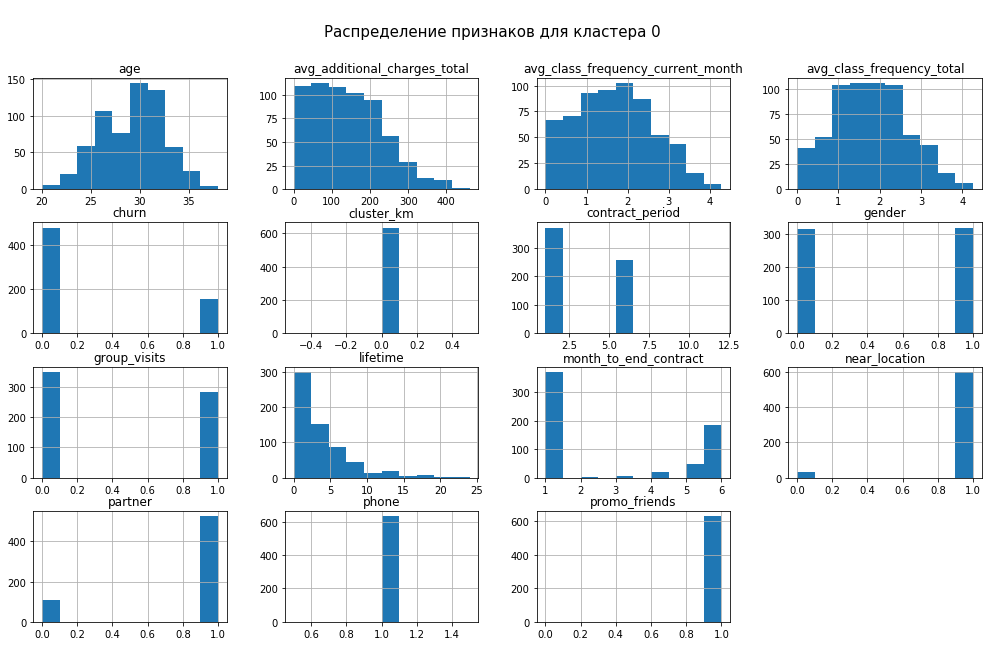

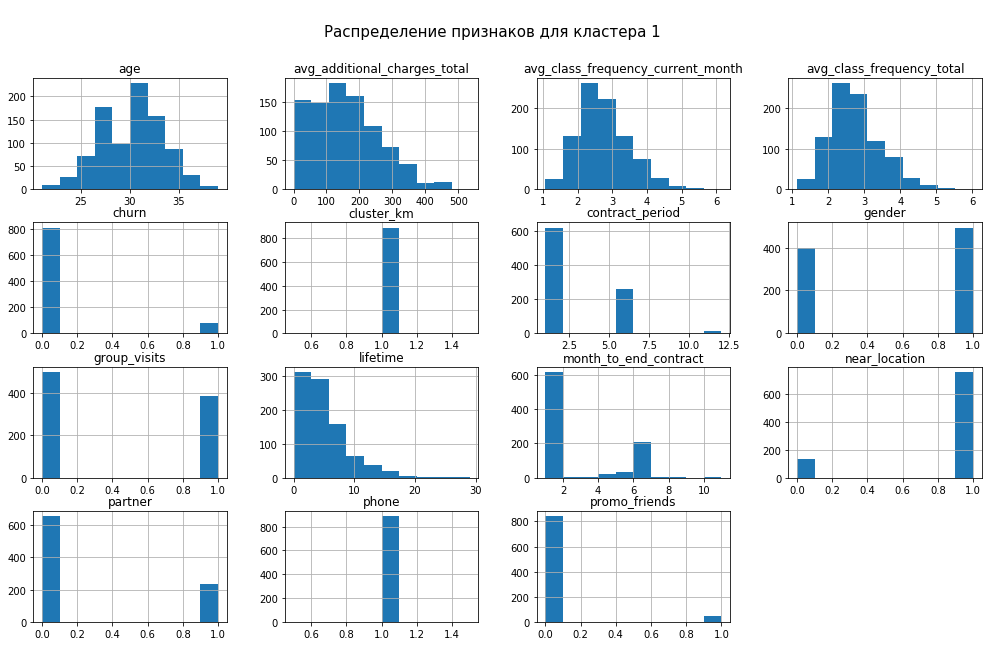

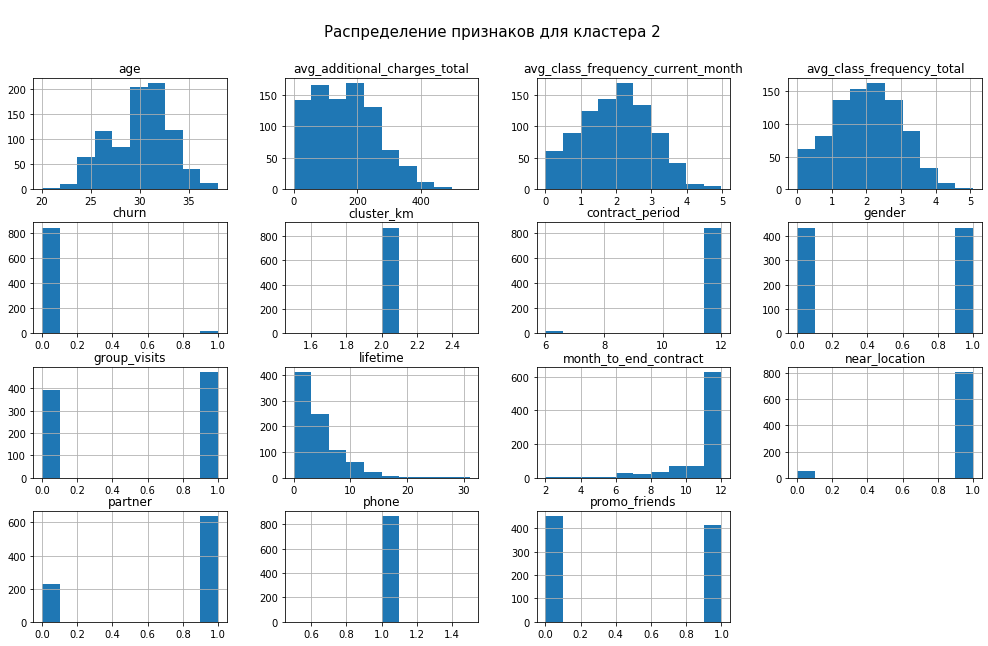

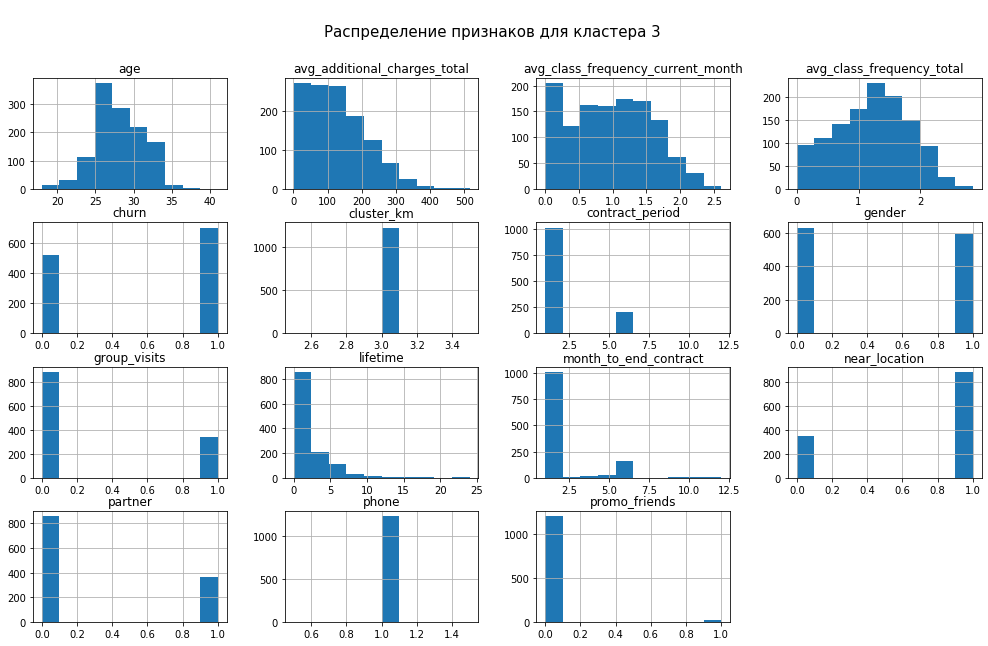

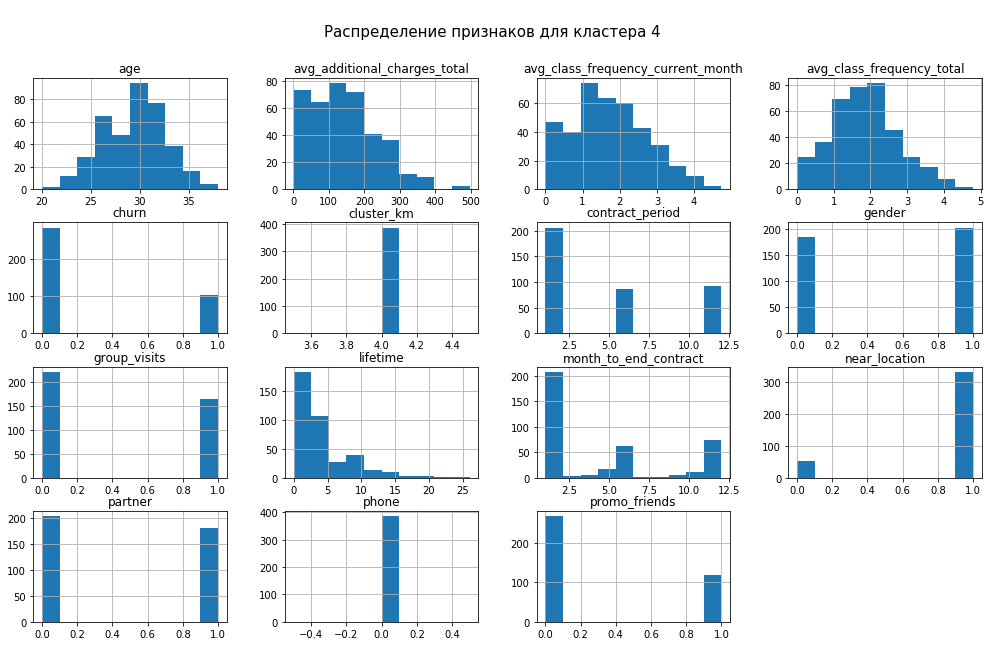

In [37]:
for value in [0, 1, 2, 3, 4]:
  df[df['cluster_km']==value].hist(figsize=(17,10))
  plt.suptitle('\nРаспределение признаков для кластера {}'.format(value), fontsize = 15)
  plt.show()

# 🧠 Общий вывод <a id="total"></a>
 

Выводы по имеющимся данным:

    Распределение по полу примерно одинаково
    Большинство клиентов (85%) живет или работает рядом с фитнес-клубом
    Примерно половина клиентов являются сотрудниками партнерских организаций
    Около 30% клиентов пришли по программе "Приведи друга"
    Известны мобильные номера примерно 90% клиентов
    Средняя длительность абонементов клиентов - 4.6 месяцев
    Около 40% клиентов посещают групповые занятия
    Средний возраст клиентов 29 лет
    Средние дополнительные расходы на клиента - 146
    Средний срок до окончания договора - 4.3 месяцев
    Среднее время с момента первого обращения в фитнес-центр - 3.7 месяцев
    Средняя частота посещений за все время - 1.87 раз в неделю
    Средняя частота посещений за последний месяц - 1.76 раз в неделю
    Доля оттока - 27%

Выводы на основе отличий признаков у клиентов, попавших в отток и оставшихся:

    Распределение по полу не отличается
    Ближе живущие или работающие клиенты реже попадают в отток
    Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб чем остальные клиенты
    Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят в отток
    Наличие мобильного номера клиента не отличается в группах
    Средняя длительность договора полне логично больше у оставшихся пользователей, у большей части клиентов в оттоке срок договора составляет 1 месяц (скорее это говорит о том, что чаще клиенты заключают договор на 1 месяц).
    Оставшиеся пользователи чаще ходят на групповые занятия (хотя возможно, что в отток попали те, кто еще не успел начать ходить на них)
    У групп есть разница в среднем возрасте клиентов
    Есть небольшое различие в выручке от других услуг фитнес-центра
    Оставшееся время до окончания срока действия договора логично больше у оставшихся клиентов.
    У клиентов в оттоке меньше среднее количество посещений в неделю за всё время
    Количество посещений в предыдущий месяц в два раза ниже у клиентов в оттоке

Мы разбили всех наших клиентов на 5 групп.

    Как выяснилось, большинство клиентов живет или работает неподалеку от фитнес-центра.
    
    Кластер 0 – 16% от всех посетителей фитнес-клуба
        Отток - 24%
        Живут или работают недалеко от фитнес-центра
        В основном обладатели среднесрочных абонементов на 3 месяца
        Недавно купили абонемент
        
    Кластер 1 – 22% от всех посетителей фитнес-клуба
        Отток - 8%
        Живут или работают недалеко от фитнес-центра
        Чаще всех посещают клуб - 2.81 раз в неделю
        Договора НЕ на длительный срок - в среднем 2.8 месяцев
        
    Кластер 2 – 22% от всех посетителей фитнес-клуба
        Отток - 2% - самый низкий
        Живут или работают недалеко от фитнес-центра
        Преобладают сотрудники компаний-партнеров - 78%
        Заключают договора на длительный срок - 12 месяцев
        Чаще всех посещают групповые занятия - 54%
        Чаще всех пришли по промо акции
        
    Кластер 3 – 31% от всех посетителей фитнес-клуба
        Отток - 57%
        Похожи на кластер 0, но живут или работают в другом районе
        Низкий % - 7% пришли по промо акции
        Реже всех посещают групповые занятия
        
    Кластер 4 – 9% от всех посетителей фитнес-клуба
        Отток - 26%
        Живут или работают недалеко от фитнес-центра
        В среднем 4.5 месяцев контракты


### 🧠 Рекомендации
Мне кажется, что нужно общаться с менеджерами. Добавить в таблицу новую фичу, какой менеджер первично делал экскурсию в зале, кто оформлял сделку? Выяснить влияет ли менеджер на отток. 

Возможно ввести бесплатное вводное первое групповое занятие для новых клиентов из рисковых кластеров. Возможно они заведут знакомства с другими клиентами, вместе с другом реально удобнее тренить и меньше риска пропустить тренировку.

Не просто ознакомлять клиента с новыми акциями через e-mail, а нужно чтобы менеджер из клуба звонил и прелагал прийти на какую-то новую тренировку.

Еще я бы собрал побольше данных, провёл анкетирование новых клиентов из рисковых сегментов, чтобы лучше их узнать. Явно есть како-то фактор, которого нет у нас в таблице.

[Вернуться к началу](#return_to_top)